In [1]:
import json
from dotenv import load_dotenv
import os
import time
from tqdm import tqdm
import random
import numpy as np
from collections import defaultdict

import pymongo
from bson import ObjectId
import matplotlib.pyplot as plt

import consts
from schema import Character, Run, RunSummary

from rio_requests import character_run_summaries, get_run_from_id

In [2]:
database_runs = open('data/raideriknow.runs.json', 'r')
database_runs = json.load(database_runs)
database_runs = [Run.from_json(run) for run in database_runs]
database_run_ids = { run.keystone_run_id: run for run in database_runs }

database_characters = open('data/raideriknow.characters.json', 'r')
database_characters = json.load(database_characters)
database_characters = [Character.from_json(character) for character in database_characters]
database_characters = sorted(database_characters, key=lambda character: character.name)
database_character_ids = { character.id: character for character in database_characters }
database_character_oids = { character._id: character for character in database_characters }

In [3]:
print(len(database_characters))
print(len(database_runs))

77915
232433


In [4]:
def sample_runs(n) :
    return random.sample(database_runs, n)

def sample_characters(n) :
    return random.sample(database_characters, n)

def sample_database_runs_above_limit() :
    return [run for run in database_runs if run.mythic_level >= consts.MYTHIC_RUN_LEVEL_LIMIT]

def sample_database_characters_above_limit() :
    runs_above_limit = sample_database_runs_above_limit()
    character_oids = set()
    for run in runs_above_limit :
        roster = run.roster
        for char_oid in roster :
            character_oids.add(str(char_oid))
    
    return [database_character_oids[oid] for oid in character_oids]

database_runs_above_limit = sample_database_runs_above_limit()
database_characters_above_limit = sample_database_characters_above_limit()
print(len(database_characters_above_limit))
print(len(database_runs_above_limit))


55981
178274


In [5]:
"""
rough calculation
250,000 runs
each run has 5 characters
1,250,000 character-run operations
"""
def precompute_runs_per_character(d_runs) :
    runs_per_character = {}
    for run in tqdm(d_runs) :
        for character_oid in run.roster :
            character_id = str(character_oid)
            if character_id not in runs_per_character :
                runs_per_character[character_id] = []
            runs_per_character[character_id].append(run)

    return runs_per_character

runs_per_char = precompute_runs_per_character(database_runs)
runs_per_char_above_limit = precompute_runs_per_character(database_runs_above_limit)

100%|██████████| 178274/178274 [00:00<00:00, 884291.12it/s]


In [6]:
def get_runs_with_character(character) :
    return runs_per_char[str(character._id)] if str(character._id) in runs_per_char else []

def get_runs_with_characters(characters) :
    runs = []
    for character in characters :
        runs += get_runs_with_character(character)
    return runs

In [7]:
example_character = database_characters[0]
example_runs = get_runs_with_character(example_character)
print(f'Example character: {example_character.name} ({example_character.id})')
print(f'Number of runs: {len(example_runs)}')
print(f'Example run: {example_runs[0].to_json()}')

Example character: Aackcamiwema (204603169)
Number of runs: 31
Example run: {'keystone_run_id': 22031134, 'completed_at': {'$date': '2024-01-25T02:00:34.000Z'}, 'dungeon': {'id': 9028, 'name': "Atal'Dazar"}, 'keystone_team_id': 266158471, 'mythic_level': 26, 'roster': [ObjectId('65e1303de63558d7ed4d0a3d'), ObjectId('65e13047e63558d7ed4d2c78'), ObjectId('65e1303de63558d7ed4d0aa0'), ObjectId('65e13047e63558d7ed4d2cf6'), ObjectId('65e1301de63558d7ed4ca7bf')], 'season': 'season-df-3', 'weekly_modifiers': ['Fortified', 'Incorporeal', 'Sanguine']}


In [8]:
def avg_runs_per_character(d_chars):
    avg_runs = 0
    no_run_characters = []
    for character in tqdm(d_chars):
        runs = get_runs_with_character(character)
        if len(runs) == 0:
            no_run_characters.append(character)
            continue

        avg_runs += len(runs)

    avg_runs /= (len(d_chars) - len(no_run_characters))
    # print(f'Number of characters with no runs: {len(no_run_characters)}')

    return avg_runs

avg_runs = avg_runs_per_character(database_characters)
print(f'Average number of runs per character: {avg_runs}')
avg_runs_above_limit = avg_runs_per_character(database_characters_above_limit)
print(f'Average number of runs per character above limit: {avg_runs_above_limit}')


100%|██████████| 77915/77915 [00:00<00:00, 1311698.53it/s]


Average number of runs per character: 14.989436210966218


100%|██████████| 55981/55981 [00:00<00:00, 1496207.46it/s]

Average number of runs per character above limit: 20.048230649684715


In [9]:
def avg_keystone_level(d_runs):
    avg_level = 0
    for run in tqdm(d_runs):
        avg_level += run.mythic_level

    avg_level /= len(d_runs)
    print(f'Average keystone level: {avg_level}')

avg_keystone_level(database_runs)
avg_keystone_level(database_runs_above_limit)

100%|██████████| 232433/232433 [00:00<00:00, 10150817.48it/s]


Average keystone level: 25.478318483175798


100%|██████████| 178274/178274 [00:00<00:00, 10173685.34it/s]

Average keystone level: 26.046961418939386


100%|██████████| 178274/178274 [00:00<00:00, 7508815.45it/s]


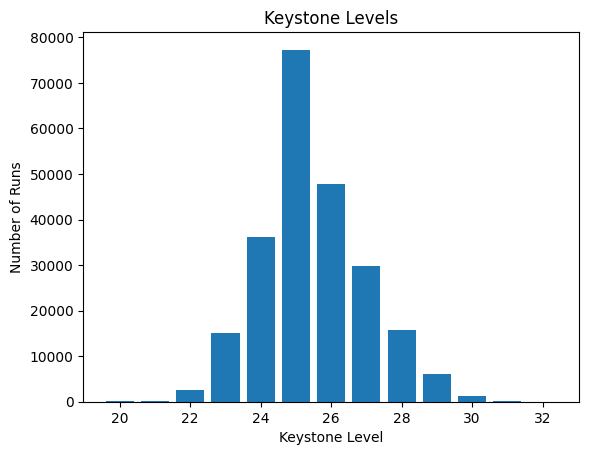

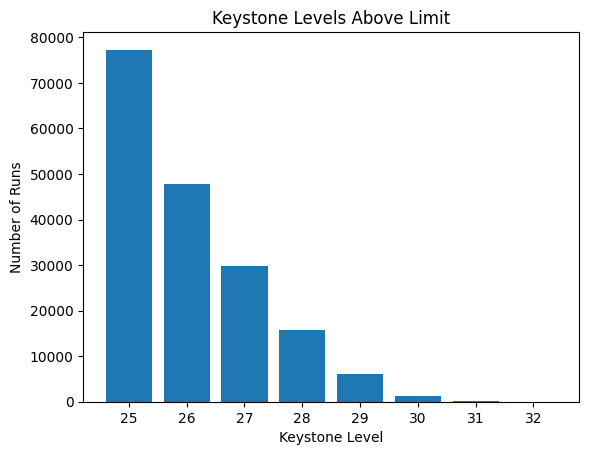

In [10]:
def runs_per_keystone_level(d_runs):
    levels = {}
    for run in tqdm(d_runs):
        level = run.mythic_level
        if level not in levels:
            levels[level] = 0
        levels[level] += 1

    return levels

levels = runs_per_keystone_level(database_runs)
levels_above_limit = runs_per_keystone_level(database_runs_above_limit)

def plot_levels(levels, title):
    plt.bar(levels.keys(), levels.values())
    plt.title(title)
    plt.xlabel('Keystone Level')
    plt.ylabel('Number of Runs')
    plt.show()

plot_levels(levels, 'Keystone Levels')
plot_levels(levels_above_limit, 'Keystone Levels Above Limit')

100%|██████████| 77915/77915 [00:01<00:00, 67702.14it/s]


Average number of adjacent characters: 34.48952063145736
Median number of adjacent characters: 12.0


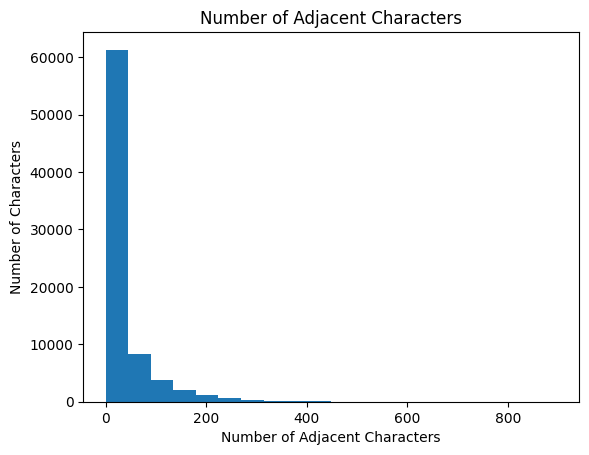

In [11]:
def num_adj_chars(character) :
    runs = get_runs_with_character(character)
    adj_chars = set()
    for run in runs :
        for char_oid in run.roster :
            adj_chars.add(str(char_oid))
    return len(adj_chars)

adj_char_counts = []
for character in tqdm(database_characters) :
    adj_char_counts.append(num_adj_chars(character))
    

avg_adj_chars = sum(adj_char_counts) / len(adj_char_counts)
median_adj_chars = np.median(adj_char_counts)

print(f'Average number of adjacent characters: {avg_adj_chars}')
print(f'Median number of adjacent characters: {median_adj_chars}')

def plot_adj_chars(adj_char_counts) :
    num_bins = 20
    plt.hist(adj_char_counts, bins=num_bins)
    plt.title('Number of Adjacent Characters')
    plt.xlabel('Number of Adjacent Characters')
    plt.ylabel('Number of Characters')
    plt.show()

plot_adj_chars(adj_char_counts)

100%|██████████| 178274/178274 [00:00<00:00, 4623298.74it/s]

Average number of team occurences: 1.2843660033928088
Median number of team occurences: 1.0
Most frequent team: 257277245 (128)


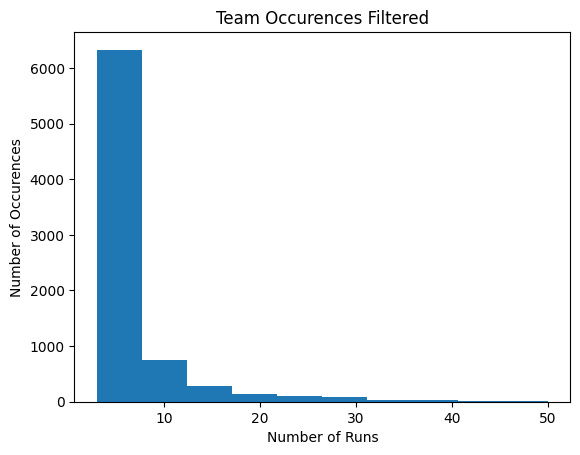

In [12]:
def team_play_occurences(d_runs) :
    teams = defaultdict(int)
    for run in tqdm(d_runs) :
        team = run.keystone_team_id
        teams[team] += 1    

    return teams

team_occurences = team_play_occurences(database_runs)
team_occurences_above_limit = team_play_occurences(database_runs_above_limit)
avg_team_occurences = sum(team_occurences.values()) / len(team_occurences)
median_team_occurences = np.median(list(team_occurences.values()))
most_frequent_team = max(team_occurences, key=team_occurences.get)

print(f'Average number of team occurences: {avg_team_occurences}')
print(f'Median number of team occurences: {median_team_occurences}')
print(f'Most frequent team: {most_frequent_team} ({team_occurences[most_frequent_team]})')
"""
Keystone team id of 257277245
Number of occurences: 128
"""

def plot_teams(teams, title, lower_limit=3, upper_limit=50) :
    teams = { team: count for team, count in teams.items() if count >= lower_limit and count <= upper_limit}
    plt.hist(teams.values(), bins=10)
    plt.title(title)
    plt.xlabel('Number of Runs')
    plt.ylabel('Number of Occurences')
    plt.show()

plot_teams(team_occurences, 'Team Occurences Filtered')

In [48]:
# https://www.reddit.com/r/wow/comments/13vqsbw/an_accurate_formula_for_m_score_calculation_in/
def calc_run_score (run) :
    # we assume all runs are above 20, so have 3 affixes
    # this might need to change for future seasons
    # assume 0 timer bonus
    return 7 * run.mythic_level + 30

class CharTopRuns (object) :
    def __init__ (self, char) :
        self.char = char
        runs = get_runs_with_character(char)
        self.top_runs = {
            dungeon_id: {
                'Tyrannical': None,
                'Fortified': None,
            }
            for dungeon_id in consts.DUNGEON_IDS
        }

        for run in runs :
            dungeon_id = run.dungeon['id']
            major_affix = 'Fortified' if 'Fortified' in run.weekly_modifiers else 'Tyrannical'
            score = calc_run_score(run)

            if self.top_runs[dungeon_id][major_affix] is None or score > calc_run_score(self.top_runs[dungeon_id][major_affix]) :
                self.top_runs[dungeon_id][major_affix] = run
    

    def overall_score (self) :
        score = 0

        for dungeon_id in consts.DUNGEON_IDS :
            score_1 = 0
            score_2 = 0
            if self.top_runs[dungeon_id]['Fortified'] is not None :
                score_1 = calc_run_score(self.top_runs[dungeon_id]['Fortified'])
            
            if self.top_runs[dungeon_id]['Tyrannical'] is not None :
                score_2 = calc_run_score(self.top_runs[dungeon_id]['Tyrannical'])

            dung_score = 1.5 * max(score_1, score_2) + 0.5 * min(score_1, score_2)

            score += dung_score
            
        return score
    

    def top_runs (self) :
        return self.top_runs
    
    def top_runs_flattened (self) :
        return list(filter(lambda run: run, [run for dungeon in self.top_runs.values() for run in dungeon.values()]))
    

ex_char_name = "Vexea"
example_character = list(filter(lambda char: char.name == ex_char_name, database_characters))[0]
ex_char_top_runs = CharTopRuns(example_character)
print(f'Example character: {example_character.name} ({example_character.id})')
print(f'Overall score: {ex_char_top_runs.overall_score()}')
# not completely accurate, but the data was taken a while ago

Example character: Vexea (135683693)
Overall score: 3710.5


In [49]:
TITLE_SCORE = 3650

In [50]:
def get_title_range_chars (title_score) :
    title_range_chars = []
    for character in tqdm(database_characters) :
        char_top_runs = CharTopRuns(character)
        if char_top_runs.overall_score() >= title_score :
            title_range_chars.append(character)
    return title_range_chars

title_range_chars = get_title_range_chars(TITLE_SCORE)
print(f'Number of characters in title range: {len(title_range_chars)}')
print(f'Example character: {title_range_chars[0].name} ({title_range_chars[0].id})')

100%|██████████| 77915/77915 [00:00<00:00, 82084.41it/s]

Number of characters in title range: 1117
Example character: Aaeldin (60145404)


In [51]:
def title_range_runs(title_score) :
    title_range_runs = []
    title_range_run_ids = set()
    for character in tqdm(database_characters) :
        char_top_runs = CharTopRuns(character)
        if char_top_runs.overall_score() >= title_score :
            top_runs = char_top_runs.top_runs_flattened()
            top_runs = filter(lambda run: run.keystone_run_id not in title_range_run_ids, top_runs)
            for run in top_runs :
                title_range_runs.append(run)
                title_range_run_ids.add(run.keystone_run_id)
    
    return title_range_runs

title_range_runs = title_range_runs(TITLE_SCORE)
print(f'Number of runs in title range: {len(title_range_runs)}')
print(f'Example run: {title_range_runs[0].to_json()}')

100%|██████████| 77915/77915 [00:01<00:00, 76138.92it/s]

Number of runs in title range: 8366
Example run: {'keystone_run_id': 26997836, 'completed_at': {'$date': '2024-02-20T05:18:41.000Z'}, 'dungeon': {'id': 9028, 'name': "Atal'Dazar"}, 'keystone_team_id': 271438692, 'mythic_level': 29, 'roster': [ObjectId('65e12fe6e63558d7ed4bfc92'), ObjectId('65e130d8e63558d7ed4efc40'), ObjectId('65e12fe5e63558d7ed4bf85d'), ObjectId('65e12fe4e63558d7ed4bf566'), ObjectId('65e12fe3e63558d7ed4bf001')], 'season': 'season-df-3', 'weekly_modifiers': ['Tyrannical', 'Storming', 'Raging']}


100%|██████████| 168359/168359 [00:00<00:00, 2062007.28it/s]


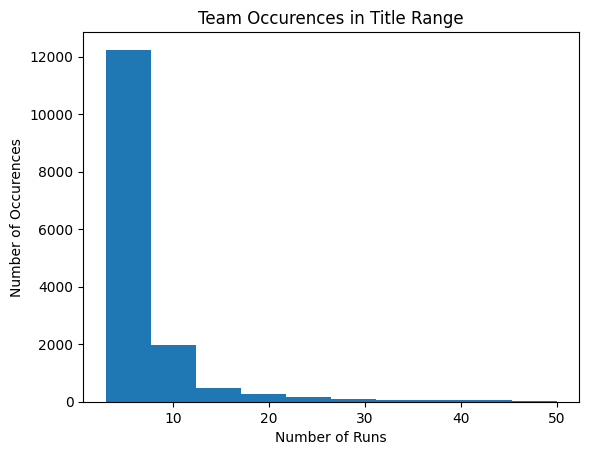

Average number of team occurences in title range: 3.4761216525922407
Median number of team occurences in title range: 2.0


In [33]:
title_team_occurences = team_play_occurences(get_runs_with_characters(title_range_chars))
plot_teams(title_team_occurences, 'Team Occurences in Title Range')
print(f'Average number of team occurences in title range: {sum(title_team_occurences.values()) / len(title_team_occurences)}')
print(f'Median number of team occurences in title range: {np.median(list(title_team_occurences.values()))}')

100%|██████████| 1117/1117 [00:00<00:00, 1986869.20it/s]


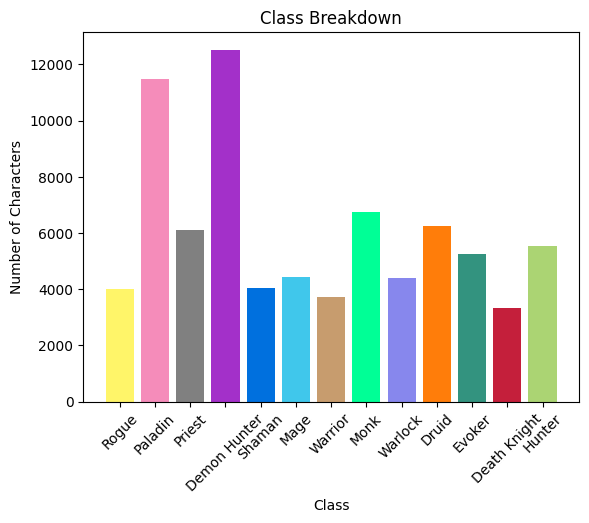

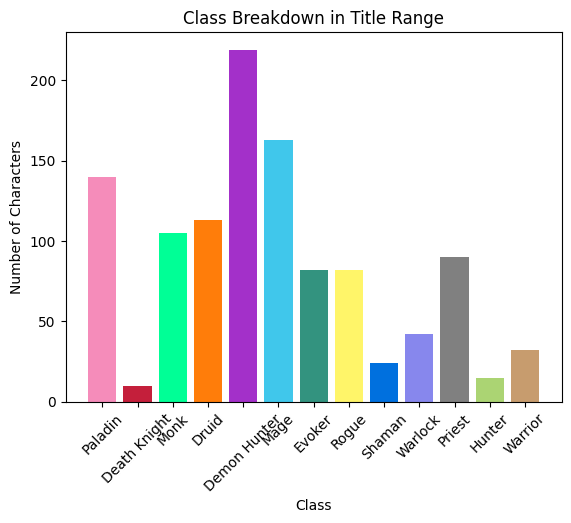

In [34]:
def class_breakdown(d_chars) :
    classes = defaultdict(int)
    for character in tqdm(d_chars) :
        classes[character.class_type['name']] += 1
    return classes

class_breakdown_chars = class_breakdown(database_characters)
title_class_breakdown_chars = class_breakdown(title_range_chars)

def plot_class_breakdown(classes, title) :
    plt.bar(classes.keys(), classes.values(), color=[consts.CLASS_COLORS[class_name] for class_name in classes.keys()])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Characters')
    plt.xticks(rotation=45)
    plt.show()

plot_class_breakdown(class_breakdown_chars, 'Class Breakdown')
plot_class_breakdown(title_class_breakdown_chars, 'Class Breakdown in Title Range')


In [35]:
avg_title_runs = avg_runs_per_character(title_range_chars)
print(f'Average number of runs per character in title range: {avg_title_runs}')

100%|██████████| 1117/1117 [00:00<00:00, 1262132.97it/s]

Average number of runs per character in title range: 150.72426141450313


100%|██████████| 168359/168359 [00:00<00:00, 1674378.00it/s]


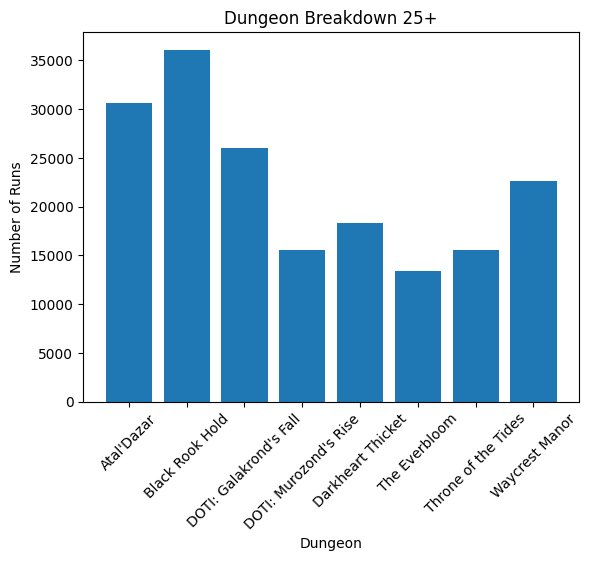

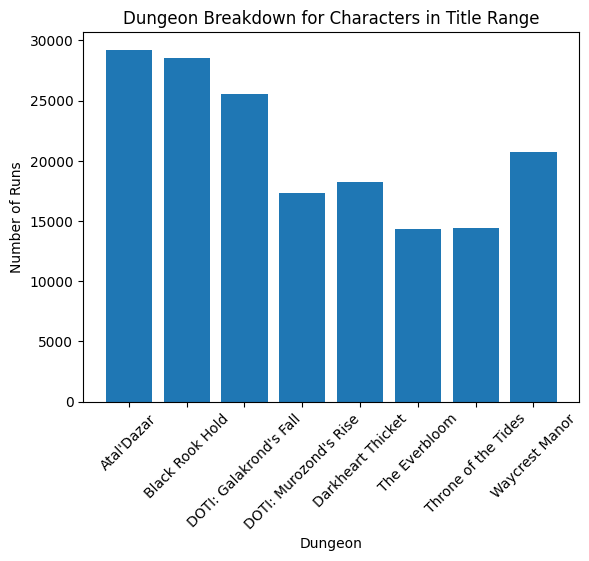

In [36]:
def dungeon_breakdown(d_runs) :
    dungeons = defaultdict(int)
    for run in tqdm(d_runs) :
        dungeons[run.dungeon['name']] += 1
    return dungeons

dungeon_breakdown_runs_above_limit = dungeon_breakdown(database_runs_above_limit)
dungeon_breakdown_title_range = dungeon_breakdown(get_runs_with_characters(title_range_chars))

def plot_dungeon_breakdown(dungeons, title) :
    dungs = sorted(dungeons.items(), key=lambda x: x[0])
    plt.bar([dung[0] for dung in dungs], [dung[1] for dung in dungs])
    plt.title(title)
    plt.xlabel('Dungeon')
    plt.ylabel('Number of Runs')
    plt.xticks(rotation=45)
    plt.show()

plot_dungeon_breakdown(dungeon_breakdown_runs_above_limit, 'Dungeon Breakdown 25+')
plot_dungeon_breakdown(dungeon_breakdown_title_range, 'Dungeon Breakdown for Characters in Title Range')
